#flow through llm->rag-> in langgraph

In [115]:
from langchain_groq import ChatGroq
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langgraph.graph import START,StateGraph,END
from typing import Annotated
from typing import TypedDict
from IPython.display import display,Image
from langgraph.graph.message import add_messages
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode,tools_condition
from langchain.tools import tool
from langchain_community.document_loaders import PyPDFLoader
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [92]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [93]:
os.environ["HF_TOKEN"]=os.getenv("HF_TOKEN")

In [94]:
embedding=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

In [95]:
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [96]:
llm=ChatGroq(model="gemma2-9b-it")

In [97]:
llm.invoke("what is gen ai")

AIMessage(content='Generative AI, or Gen AI, is a type of artificial intelligence that focuses on creating new content. \n\nThink of it like this: instead of just analyzing existing data, Gen AI learns the patterns and structures within that data and uses that knowledge to generate something original. This "something" can take many forms:\n\n* **Text:** Writing stories, poems, articles, code, dialogue, and more.\n* **Images:** Creating paintings, photographs, illustrations, and even 3D models.\n* **Audio:** Generating music, sound effects, and realistic speech.\n* **Video:** Synthesizing short videos or animations.\n\n**Here\'s how it works in a nutshell:**\n\n1. **Training:** Gen AI models are trained on massive datasets of existing content. This allows them to learn the underlying rules and patterns of that content.\n2. **Generation:** Once trained, the model can use this knowledge to generate new content based on a given prompt or input.\n\n**Some popular examples of Gen AI:**\n\n* 

In [98]:
loader=PyPDFLoader(file_path="C:\\Users\\user\\OneDrive\\Desktop\\langgraph\\temp.pdf")
docs=loader.load()

In [99]:
documents=RecursiveCharacterTextSplitter(chunk_size=400,chunk_overlap=40).split_documents(docs)

In [100]:
documents

[Document(metadata={'source': 'C:\\Users\\user\\OneDrive\\Desktop\\langgraph\\temp.pdf', 'page': 0}, page_content='From Wikipedia, the free encyclopedia \nAn illustration of main components of the \ntransformer model from the paper \n"Attention Is All You Need"[1] is a 2017 landmark[2][3] research paper in machine learning authored by \neight scientists working at Google. The paper introduced a new deep learning architecture known as'),
 Document(metadata={'source': 'C:\\Users\\user\\OneDrive\\Desktop\\langgraph\\temp.pdf', 'page': 0}, page_content='the transformer, based on the attention mechanism proposed in 2014 by Bahdanau et al.[4] It is \nconsidered a foundational[5] paper in modern artificial intelligence, as the transformer approach has \nbecome the main architecture of large language models like those based on GPT.[6][7] At the time, the'),
 Document(metadata={'source': 'C:\\Users\\user\\OneDrive\\Desktop\\langgraph\\temp.pdf', 'page': 0}, page_content='focus of the research w

In [101]:
db=FAISS.from_documents(documents=documents,embedding=embedding)

In [102]:
vector_db=db.as_retriever()

In [103]:
input="what is transformer"

In [104]:
vector_db.get_relevant_documents(input)

[Document(id='afd4a1c3-aa0a-48e3-b69e-661695036770', metadata={'source': 'C:\\Users\\user\\OneDrive\\Desktop\\langgraph\\temp.pdf', 'page': 0}, page_content='"Transformer" was picked because Uszkoreit liked the sound of that word.[9] \nAn early design document was titled "Transformers: Iterative Self-Attention and Processing for \nVarious Tasks", and included an illustration of six characters from the Transformers animated show. \nThe team was named Team Transformer.[8]'),
 Document(id='b26b09a8-d79f-400c-8e99-305b9d4ba038', metadata={'source': 'C:\\Users\\user\\OneDrive\\Desktop\\langgraph\\temp.pdf', 'page': 0}, page_content='Some early examples that the team tried their Transformer architecture on included English-to-\nGerman translation, generating Wikipedia articles on "The Transformer", and parsing. These \nconvinced the team that the Transformer is a general purpose language model, and not just good for \ntranslation.[9] \nAs of 2024, the paper has been cited more than 100,000 t

In [105]:
class AgentState(TypedDict):
    messages:Annotated[list,add_messages]  

In [106]:
def function_1(state:AgentState):
    print("==> entering into the llm <==")
    messages=state["messages"]
    question=messages
    print(f"the llm question {question}")
    response=llm.invoke(question)
    return {"messages":[response]}

In [107]:
def function_2(state:AgentState):
    print("==> entering into the rag <==")
    messages=state["messages"]
    question=messages[-1]
    print(f"the rag question is {question}")

    template="""
      Answer the following question based on the user query
      {context}
      Question:{question}
    """

    prompt=ChatPromptTemplate.from_template(template)

    chain=prompt|llm|StrOutputParser()

    response=chain.invoke({"context":vector_db,"question":question})
    return {"messages":[response]}

In [108]:
#state={"messages":["what is gen ai"]}

In [109]:
#function_2(state)

In [110]:
graph=StateGraph(AgentState)

In [111]:
graph.add_node("llm",function_1)
graph.add_node("rag",function_2)
graph.add_edge("llm","rag")
graph.set_entry_point("llm")
graph.set_finish_point("rag")

In [112]:
app=graph.compile()

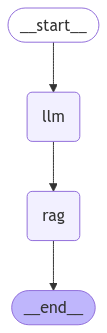

In [113]:
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [114]:
app.invoke({"messages":["what is gen ai"]})

==> entering into the llm <==
the llm question [HumanMessage(content='what is gen ai', additional_kwargs={}, response_metadata={}, id='a8531ffe-0a6c-422d-b245-c3033d751227')]
==> entering into the rag <==
the rag question iscontent="**Generative AI** (Gen AI) is a type of artificial intelligence that focuses on creating new content, rather than simply analyzing or classifying existing data. \n\nHere's a breakdown:\n\n**What it does:**\n\n* **Generates new data:** Gen AI models can produce various forms of content, including:\n    * **Text:** Articles, stories, poems, dialogue, code\n    * **Images:** Photos, drawings, artwork\n    * **Audio:** Music, speech, sound effects\n    * **Video:** Animations, short films\n    * **Other:** 3D models, synthetic data\n\n* **Learns patterns:** Gen AI models learn these patterns from massive datasets of existing content.\n\n* **Creates variations:** Based on the learned patterns, they can generate new content that resembles the training data but is

{'messages': [HumanMessage(content='what is gen ai', additional_kwargs={}, response_metadata={}, id='a8531ffe-0a6c-422d-b245-c3033d751227'),
  AIMessage(content="**Generative AI** (Gen AI) is a type of artificial intelligence that focuses on creating new content, rather than simply analyzing or classifying existing data. \n\nHere's a breakdown:\n\n**What it does:**\n\n* **Generates new data:** Gen AI models can produce various forms of content, including:\n    * **Text:** Articles, stories, poems, dialogue, code\n    * **Images:** Photos, drawings, artwork\n    * **Audio:** Music, speech, sound effects\n    * **Video:** Animations, short films\n    * **Other:** 3D models, synthetic data\n\n* **Learns patterns:** Gen AI models learn these patterns from massive datasets of existing content.\n\n* **Creates variations:** Based on the learned patterns, they can generate new content that resembles the training data but is unique.\n\n**How it works:**\n\n* **Deep learning:** Gen AI primarily 